In [1]:
# import packages
from sma import run_snscrape, sentiment, unsupervised
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from datetime import datetime
import pickle
import os
import gensim
from os import listdir
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fergu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk

Firstly we need to build our dataset on which we will perform our analysis. To do this I propose to use the SNScrape package which enables us to pull social content from a range of platforms, some with better access to posts than others. For example Meta owned platforms (Facebook, Instagram) tend to have greater restrictions on which data can be pulled through aggregators, while Twitter is fully exposed publicly and therefore returns higher qulity data when running the SNScrape functionality.

To simplify executiong of SNScrape functionality, I have created a simple wrapper function which validates the format of the arguments given, creates the API payload and passes it to the SNScrape excution function.

<u>A note on date ranges:</u>
It is worth noting that after significant testing i found that pulling large volumes of tweets in a single go can lead to excessive run times. This appears to result from the fact that the time taken to convert the response object - returned by snscrape - to a pandas dataframe increases drastically as the number of tweets returned increases. To avoid this, I suggest slicing your date range to smaller increments and iteratively pulling tweets for each - which is the approach I implement below

### Pull intial data

In [2]:
# define the terms and date range for which we wish to pull tweets
term = 'natwest'
timeframes = [
    ['2021-01-01', '2021-02-28'],
    ['2021-03-01', '2021-04-30'],
    ['2021-05-01', '2021-06-30'],
    ['2021-07-01', '2021-08-31'],
    ['2021-09-01', '2021-10-31'],
    ['2021-11-01', '2021-12-31']
]

In [ ]:
# pull tweets for each date range in turn
for timeframe in tqdm(timeframes):
    return_df = run_snscrape.scrape_twitter(term, date_range=timeframe, lang='en', limit=None)
    
    # save the output
    output_path = 'data/raw_{}_{}.pickle'.format(term, timeframe[0])
    return_df.to_pickle(output_path)

In [3]:
# consolidate files to create complete dataset
consolidated_df = pd.DataFrame()
for file in listdir('data'):
    if 'raw_{}'.format(term) in file:
        temp = pd.read_pickle('data/{}'.format(file))
        consolidated_df = pd.concat([consolidated_df, temp], axis=0)

#remove duplicate tweets
consolidated_df = consolidated_df.drop_duplicates(subset='content', ignore_index=True)

print(f'total tweet count: {len(consolidated_df)}')

# save a file format that we can view to manually explore the data
consolidated_df.to_csv(f'data/master_{term}.csv')
# save a version in a format that enables more efficient storage and loading
consolidated_df.to_pickle(f'data/master_{term}.pickle')

total tweet count: 76145


In [4]:
consolidated_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,None,None,None,1.365813e+18,"{'username': 'peterdysart', 'id': 365487749, '...","[{'username': 'peterdysart', 'id': 365487749, ...",None,None,None,None
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,None,None,None,1.365813e+18,"{'username': 'adamwalton', 'id': 12359262, 'di...","[{'username': 'adamwalton', 'id': 12359262, 'd...",None,None,None,None
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,None,None,None,NaN,None,None,None,None,"[lowcode, automation, process]",None
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,None,None,None,1.365811e+18,"{'username': 'cakeypigdonkey', 'id': 91802436,...","[{'username': 'cakeypigdonkey', 'id': 91802436...",None,None,None,None
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,None,None,None,1.365809e+18,"{'username': 'tomwm1984', 'id': 362341111, 'di...","[{'username': 'tomwm1984', 'id': 362341111, 'd...",None,None,None,None


### Tag sentiment

Next we will tag all the posts to understand the sentiment. For social media text we will use VADER model which is specifically built on social content and therefore can account for things such as emojis and slang. Furthermore the fact it is a taxonomy based approach means we avoid the need to long compute times as well as being able to return polarity scores which can shed greater insight - such as not just whether a tweet is negative, but the degree to which it is negative

In [44]:
master_df = pd.read_pickle(f'data/master_{term}.pickle')

# we will use Vader for sentiment, and return the full polarity output
tqdm.pandas()
new_cols = ['sent_positive', 'sent_negative', 'sent_neutral', 'sent_compound', 'sentiment']
master_df[new_cols] = master_df.progress_apply(lambda x: sentiment.vader_sentiment(x['content'], return_polarities=True), axis=1, result_type='expand')

# save file
master_df.to_pickle(f'data/sentiment_{term}.pickle')
master_df.to_csv(f'data/sentiment_{term}.csv')

100%|██████████| 76145/76145 [10:51<00:00, 116.85it/s]


In [45]:
master_df = pd.read_pickle(f'data/sentiment_{term}.pickle')
master_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,sent_positive,sent_negative,sent_neutral,sent_compound,sentiment
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,"[{'username': 'peterdysart', 'id': 365487749, ...",None,None,None,None,0.089,0.074,0.837,0.1531,Positive
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,"[{'username': 'adamwalton', 'id': 12359262, 'd...",None,None,None,None,0.000,0.000,1.000,0.0000,Neutral
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,None,None,None,"[lowcode, automation, process]",None,0.000,0.000,1.000,0.0000,Neutral
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,"[{'username': 'cakeypigdonkey', 'id': 91802436...",None,None,None,None,0.000,0.144,0.856,-0.6908,Negative
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,"[{'username': 'tomwm1984', 'id': 362341111, 'd...",None,None,None,None,0.061,0.075,0.865,-0.1511,Negative


Now that we have tagged sentiment, we can plot our dataset to display the number of tweets over time, and indeed the volume of each sentiment to see if any interesting patterns or spikes emerge

In [46]:
# add a new numeric column, populated with '1', which we will plot to show the number of tweets in a given day
master_df['count'] = 1

# now we can add three binary colums to indicate whether the sentiment for each tweet is positve, negative, or neutral
# note: to retain the categorical sentiment column it helps to duplicate before breaking out to binary
master_df['temp_sentiment'] = master_df['sentiment']
master_df = pd.get_dummies(master_df, columns=['sentiment'])
master_df = master_df.rename(columns = {'temp_sentiment': 'sentiment'})

# next we will create a new Date column where we will group the datetime in our data to each distinct date
master_df['Date'] =  pd.to_datetime(master_df['date']).dt.date

master_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,sent_positive,sent_negative,sent_neutral,sent_compound,count,sentiment,sentiment_Negative,sentiment_Neutral,sentiment_Positive,Date
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,0.089,0.074,0.837,0.1531,1,Positive,0,0,1,2021-02-27
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,0.000,0.000,1.000,0.0000,1,Neutral,0,1,0,2021-02-27
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,0.000,0.000,1.000,0.0000,1,Neutral,0,1,0,2021-02-27
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,0.000,0.144,0.856,-0.6908,1,Negative,1,0,0,2021-02-27
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,0.061,0.075,0.865,-0.1511,1,Negative,1,0,0,2021-02-27


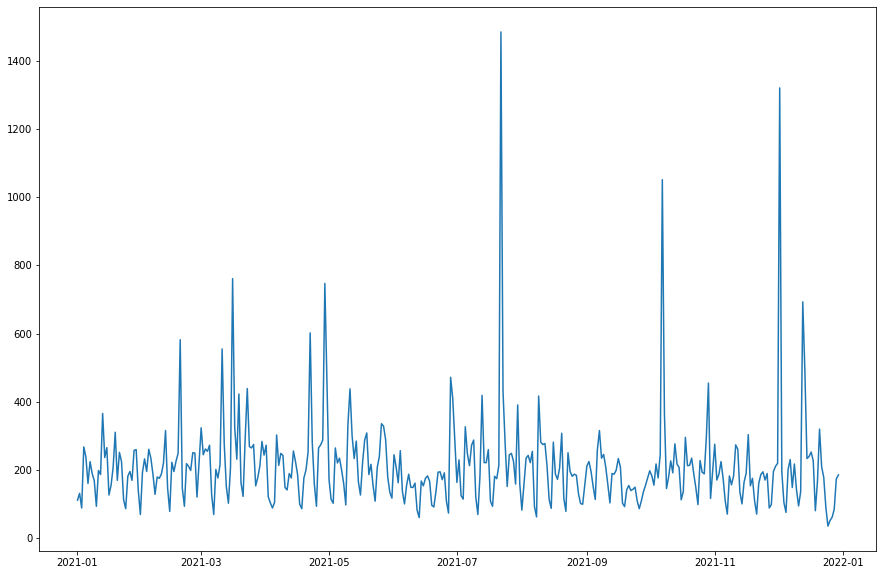

In [47]:
count_df = master_df.groupby('Date')['count'].sum()

plt.figure(figsize=(15,10))
plt.plot(count_df)

While this first view gives us a plot of the number of tweets (and retweets) per day, the plot is extremely messy and volatile - with sharp spikes.

While this view may be interesting to identify individual explosions in conversation, it is going to become almost impossible to extract meaningful insight when we come to observing the proportion of comments by sentiment. To overcome this, we can aggregate to a weekly level and observe the patterns

In [48]:
# next we will create a new Date column where we will group the datetime in our data to each distinct date
master_df['Year'] =  pd.to_datetime(master_df['Date']).dt.year
master_df['Month'] =  pd.to_datetime(master_df['Date']).dt.month
master_df['Week'] =  pd.to_datetime(master_df['Date']).dt.week

# if we were to aggregate by week, and had multiple years worth of data, we risk grouping comments across years
# despite only dealing with one year of data in this example, it is important to apply best practices
# so we will create a new column that provides the start date of each week (based on Year - Week) and aggregate to this 
master_df['Year-Week'] = pd.to_datetime(master_df['Year'].astype(str) + ' ' + master_df['Week'].astype(str) + ' 1', format='%Y %U %w').dt.date
# Note the addition of " 1" at the end indicates Monday week start (" 0" can be used for Sunday to Sunday)

master_df.sample(5)



C:\Users\fergu\AppData\Local\Temp\ipykernel_19088\3968077453.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  master_df['Week'] =  pd.to_datetime(master_df['Date']).dt.week


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,count,sentiment,sentiment_Negative,sentiment_Neutral,sentiment_Positive,Date,Year,Month,Week,Year-Week
4691,https://twitter.com/NatWest_Help/status/135770...,2021-02-05 14:51:34+00:00,"@WMFC1897 Brilliant, thanks again! Let us know...","@WMFC1897 Brilliant, thanks again! Let us know...",1357703419541270528,"{'username': 'NatWest_Help', 'id': 284540385, ...",0,0,1,0,...,1,Positive,0,0,1,2021-02-05,2021,2,5,2021-02-01
36369,https://twitter.com/SealandFlynn/status/139174...,2021-05-10 13:11:02+00:00,Discover why brands should reset their strateg...,Discover why brands should reset their strateg...,1391742577469186051,"{'username': 'SealandFlynn', 'id': 135685525, ...",0,0,0,0,...,1,Neutral,0,1,0,2021-05-10,2021,5,19,2021-05-10
57214,https://twitter.com/ReutersBiz/status/14461132...,2021-10-07 14:00:40+00:00,Britain's NatWest pleads guilty to money laund...,Britain's NatWest pleads guilty to money laund...,1446113249133355011,"{'username': 'ReutersBiz', 'id': 15110357, 'di...",1,5,4,1,...,1,Negative,1,0,0,2021-10-07,2021,10,40,2021-10-04
11431,https://twitter.com/jemmapage/status/134531846...,2021-01-02 10:38:12+00:00,@NatWest_Help I want to close down my credit c...,@NatWest_Help I want to close down my credit c...,1345318468317491201,"{'username': 'jemmapage', 'id': 299098436, 'di...",1,0,0,0,...,1,Positive,0,0,1,2021-01-02,2021,1,53,2022-01-03
6873,https://twitter.com/stikdragon/status/13537032...,2021-01-25 13:56:30+00:00,"@NatWest_Help I believe it's all in hand, I'm ...","@NatWest_Help I believe it's all in hand, I'm ...",1353703295353843713,"{'username': 'stikdragon', 'id': 593751402, 'd...",1,0,0,0,...,1,Positive,0,0,1,2021-01-25,2021,1,4,2021-01-25


In [49]:
master_df.to_pickle(f'data/master_df_{term}.pickle')

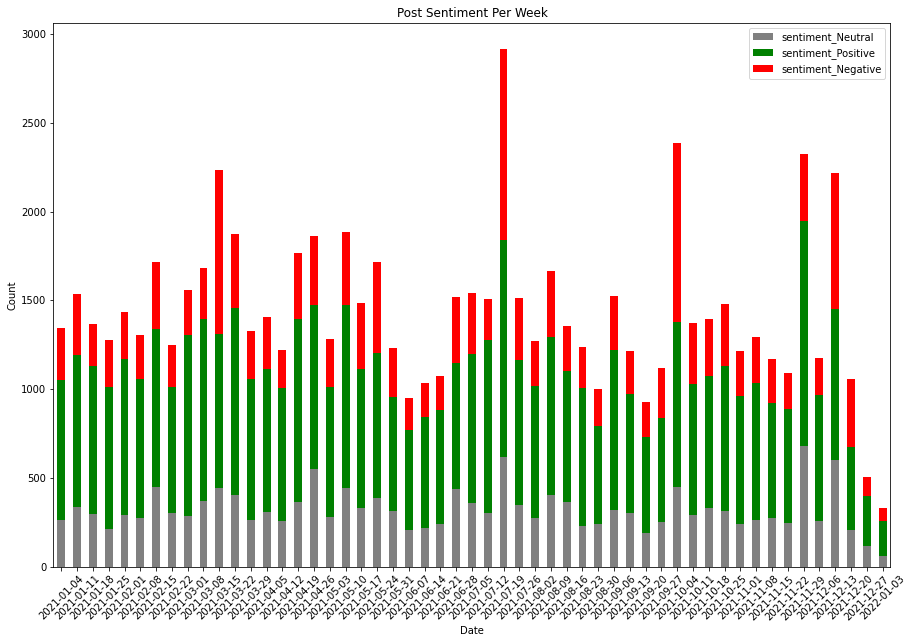

In [50]:
# create a new table by aggregating the post counts to a weekly level
agg_df = master_df.groupby(['Year-Week'])[['count', 'sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral']].sum()

# plot the stacked bar chart to show frequency of posts by sentiment
agg_df[['sentiment_Neutral', 'sentiment_Positive', 'sentiment_Negative']].plot.bar(
    stacked=True, color = ['grey', 'green', 'red'], width=0.5, figsize=(15,10))

plt.xticks(rotation = 45)
plt.title('Post Sentiment Per Week')
plt.ylabel('Count')
plt.xlabel('Date')

plt.show()


### Unsupervised clustering

To build out more detailed insights on our data it will be necessary to tag our tweets with a wider range of topics, to understand the content that users are posting about. This could be achieved by training a supervised model on a pre-determine training set, where a corpus of text documents/snippets have already been tagged to topics of interest. However, for the purpose of this project we will look to build out our own training data - through leveraging unsupervised clustering.

For this we will leverage Kmeans clustering to group tweets, based on the Euclidean distance of their text embeddings - i.e. how close together tweets are in the types of words they discuss. KMeans is a commonly used iterative algorithm which randomly initiates with a predefined number (K) of centroids. The Euclidean distance between the tweets - represented in multi-dimensional space by its embedding vector (which we will address below) - and all centroids is then computed. Tweets are then assigned to their neaest centroid to form a cluster.

The centroids are then re-initialised by taking the mean of all points (tweets) in the cluster, and the above steps are repeated - either until there is no improvement (i.e. cluster centroids stop moving) or until the maximum number of iterations specified is reached. 

In essence the objective of KMeans is to minimize the sum of distances between the data points (ebedded tweets in our case) and the cluster centroid, which in turn maximises the distance between centroids. This should result in clusters where the tweets within talk about the same content, while each cluster addresses distinct topics.

As we are only interested in new topic people are discussing, we will leverage only original tweets, not retweets or replies

In [51]:
#reset index to create an unique ID column
master_df = pd.read_pickle(f'data/master_df_{term}.pickle')
master_df = master_df.reset_index(drop=False).rename(columns={'index':'ID'})

tweets_df = master_df[(master_df['inReplyToTweetId'].isna()) & (master_df['retweetedTweet'].isna())].reset_index(drop=True)
print('There are ', str(len(tweets_df)), ' original tweets')

There are  34469  original tweets


The first step to clustering is to embed the tweets - converting them to a vector format that represents the text in multi-dimensional numeric space.

For the embedding, much literature (e.g. "Text Document Clustering: Wordnet vs. TF-IDF vs. Word Embeddings", Marcinczuk et al & "An Empirical Survey of Unsupervised Text Representation Methods on Twitter Data", Wang et al) would suggest that more advanced embedding techniques - such as BERT or other transformers models - do not necessarily perform better than more traditional wordnet or term frequency models. 

This is likely because transformers models such as BERT are specifically trained based on encoder-decoder architecture whereby the embeddings (output from the encoder part of the architecture) are abstract, with little meaning outwith the task that they were specifically tuned for. Therefore, it is likely that custom training is required on your dataset in order to extract meaningful embeddings from such models. However, tuning such large transformers models can require a great deal of GPU and time. With this in mind, we will opt for a more traditional modelling approach for generating our embeddings.

Therefor we will be opting for a simpler embedding - in our case Word2Vec. However, before we can embed our tweets we need to do some pre-processing. This involves cleaning and standardising our text, as well as removing any special characters, punctuation, or words that do not provide meaningful insight into the topic of the tweet (e.g. stopwords). Pre-processing is an art more than a science, where different processing steps may be required depending on the task at hand - so it is likely worth reading up on this seperately if unsure.

In [52]:
# perform preprocessing to clean the tweet to the core components for clustering
tqdm.pandas()
tweets_df['cleaned_tweet'] = tweets_df['content'].progress_apply(lambda x: unsupervised.clean_tweet(x))

# drop duplicates
tweets_df = tweets_df.drop_duplicates(subset=['cleaned_tweet'], inplace=False).reset_index(drop=True)

# keep just the text and cleaned columns (all that is required for us to build our training data)
tweets_df = tweets_df[['ID', 'content', 'cleaned_tweet']]

# save the cleaned dataframe
tweets_df.to_pickle(f'data/cleaned_unsupervised_{term}.pickle')

100%|██████████| 34469/34469 [05:05<00:00, 112.68it/s]


Now that we have our cleaned tweets we can embed them. While TFIDF can be effective in identifying themes, based purely on the frequency and importance of key words, I am interested in using a slightly more sophisticated method which at least learns some relationships between words. Therefore something like Word2Vec would offer a good option. We will use the Gensim package to access Word2Vec model architecture

We can train our Word2Vec model by passing it our corpus of words, which it uses to create a multi-dimensional vector space, into which it places each word (assigning it a vector to decribe its position in the vector space), with similar words near to one another. Moreover, these vectors help to describe semantic relationships between words - an example being that "King (vector) - Man (vector) + Woman (vector)" would in theory provide a vector that closely describes the word Queen.

We can then obtain a vector to describe each of our tweets by aggregating the vectors for each word in the text - for short text (as in the case of tweets) averaging the vectors tends to provide good results.

In [53]:
# read back in the data if necessary (i.e. as a checkpoint)
tweets_df = pd.read_pickle(f'data/cleaned_unsupervised_{term}.pickle')

# train our word2vec model
tweets_df['tokens'] = tweets_df['cleaned_tweet'].apply(lambda x: word_tokenize(x))
w2v_model = Word2Vec(tweets_df['tokens'], vector_size=120, window=5, min_count=2, workers=4, sg=0, seed=1)

# note: 'seed' sets the initial vectors that Word2Vec randomly initiates with
# however, you will still get slightly different results if spreading processing over multiple workers
# in order to get completely repeatable results you'd need to set 'workers = 1' for avoid thread jittering

#save the model if we need to revert to it later
w2v_model.save("data/word2vec.model")

Now we have trained the model on our data we can test to see if the results make sense. one way to do this is by passing the model a word and seeing what other words it has learned as being similar  - i.e. appear in a similar semantic context

In [54]:
# test outputs by extracting similar words
w2v_model.wv.most_similar("card")

[('direct', 0.9527410864830017),
 ('cancel', 0.9011273384094238),
 ('debit', 0.8878852725028992),
 ('order', 0.8836407661437988),
 ('visa', 0.8822133541107178),
 ('pin', 0.8675798773765564),
 ('contactless', 0.8597685694694519),
 ('clone', 0.8560994863510132),
 ('expire', 0.855146050453186),
 ('replacement', 0.850027859210968)]

In [55]:
# create the average vector for each tweet
tqdm.pandas()
tweets_df['embedding'] = tweets_df['tokens'].progress_apply(lambda x: unsupervised.obtain_tweet_vector(x, w2v_model))

# drop tweets where the vector is Null - as words not in Word2Vec vocab
tweets_df = tweets_df[~tweets_df['embedding'].isna()]

# create an input array to feed into KMeans clustering from our vector embeddings column
vectors_array = np.array(list(tweets_df['embedding']))
print(len(vectors_array))

100%|██████████| 29457/29457 [00:01<00:00, 17675.04it/s]

29453


The number of clusters we will group our data into can be determined by plotting an "elbow plot". This is achieved by iterating through a definined number of clusters and running kmeans for each, then computing the "Within Cluster Sum of Squares (WCSS)" - i.e. the sum of the squared distances from each point to the centroid of its assigned cluster. In effect it looks for how well clustered each grouping is.

We can observe this too find the optimum number of clusters - that is the number whereby we obtain a low enough average distance, and above which increasing the number of clusters leads to relatively lower improvement in spread

Computing WCSS 1 / 20
Computing WCSS 2 / 20
Computing WCSS 3 / 20
Computing WCSS 4 / 20
Computing WCSS 5 / 20
Computing WCSS 6 / 20
Computing WCSS 7 / 20
Computing WCSS 8 / 20
Computing WCSS 9 / 20
Computing WCSS 10 / 20
Computing WCSS 11 / 20
Computing WCSS 12 / 20
Computing WCSS 13 / 20
Computing WCSS 14 / 20
Computing WCSS 15 / 20
Computing WCSS 16 / 20
Computing WCSS 17 / 20
Computing WCSS 18 / 20
Computing WCSS 19 / 20


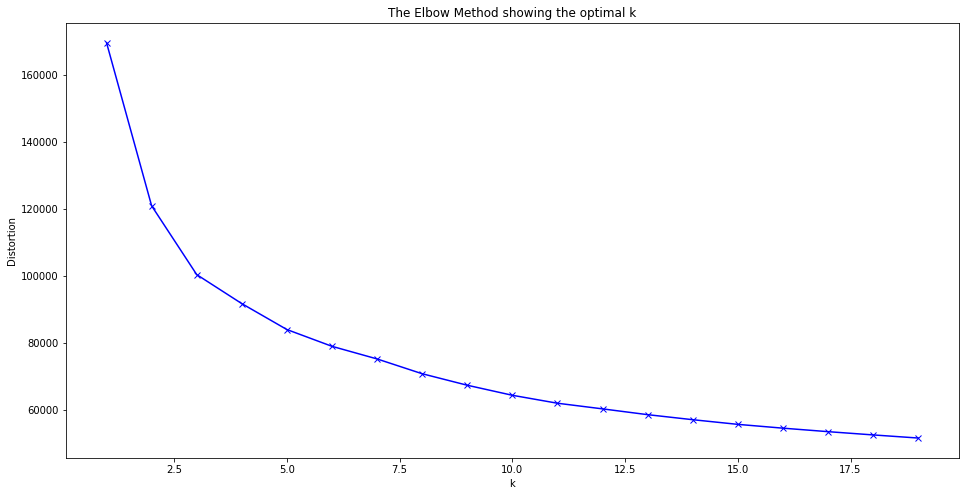

In [31]:
# plot elbow curve
unsupervised.plot_elbow(vectors_array, max_clusters=20)

From the above plot we can see that as the number of clusters increases the average spread of the clusters (the average distance squared of each point to the centroid) decreases. This indicates that the clusters formed become more consistent as the number increases - which intuitive makes sense.

However, past a certain point increasing the numbers of clusters does not result in significantly lower spread. From observing the plot, it appears that 7-10 clusters looks to be the point past which we experience diminishing returns. For the sake of this example we will take 10 clusters as it is offers us decent enough spread (for this example) and is a manageable number of analyse manually - something that we'll come to below.

In [56]:
# run clustering on dataset using preferred cluster number
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(vectors_array)

# save the kmeans model if we need to access at a later date
with open("data/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

# extract the cluster numbers from the trained model
tweets_df['cluster'] = kmeans.labels_

# save the output for manual investigation
tweets_df[['ID', 'content', 'cleaned_tweet', 'cluster']].to_csv(f'data/clustered_unsupervised_{term}.csv', index=False)
# save pickle file to be loaded in as a checkpoint if required
tweets_df[['ID', 'content', 'cleaned_tweet', 'cluster']].to_pickle(f'data/clustered_unsupervised_{term}.pickle')

We can now go ahead and manually explore the clusters we have to determine what topics or themes each is discussing. From observing the types of comments that we see in each cluster we can begin to build up a view of what each cluster is about, and record this in a matrix to use for later.

From looking at the outputted csv file, I have identified a number of well fored and consistent clusters - against which I tag the preceived topic which they discuss

In [57]:
cluster_themes = {
    0: 'sports event sponsorship',
    1: 'stance on cryptocurrencies',
    2: 'request for advice on cards/payments',
    3: 'campaigns, industry workshops and partnerships',
    4: 'generic banking news',
    5: 'noise',
    6: 'compliance and regulatory issues',
    7: 'noise',
    8: 'helpline and branch service complaints',
    9: 'issues with mobile app and online'
}

We can also test this by outputting the words in our trained word2vec model that have the greatest similarity to our cluster tweets

In [58]:
# output top words for cluster 1 - "issues with mobile app and online"
w2v_model.wv.similar_by_vector(kmeans.cluster_centers_[9], topn=15, restrict_vocab=None)

[('login', 0.9847433567047119),
 ('approval', 0.9793349504470825),
 ('unable', 0.9788128137588501),
 ('crash', 0.9778804183006287),
 ('disable', 0.977871835231781),
 ('biometric', 0.9765214920043945),
 ('function', 0.972375750541687),
 ('screen', 0.9697500467300415),
 ('down', 0.9677465558052063),
 ('browser', 0.9673590064048767),
 ('device', 0.9650512337684631),
 ('iphone', 0.9650208950042725),
 ('problem', 0.9646859169006348),
 ('reset', 0.9642794132232666),
 ('log', 0.9637383818626404)]

In [59]:
# output top words for cluster 6 - "compliance and regulatory issues"
w2v_model.wv.similar_by_vector(kmeans.cluster_centers_[6], topn=15, restrict_vocab=None)

[('criminally', 0.979974091053009),
 ('allege', 0.978516697883606),
 ('investigation', 0.9782012104988098),
 ('accuse', 0.9754127860069275),
 ('scandal', 0.9749894142150879),
 ('prosecute', 0.9748225212097168),
 ('rule', 0.9739609360694885),
 ('failing', 0.9708364605903625),
 ('law', 0.9701268672943115),
 ('admit', 0.9691255688667297),
 ('allegedly', 0.9674208760261536),
 ('gang', 0.9670417904853821),
 ('scrutinise', 0.9661484360694885),
 ('properly', 0.9660875201225281),
 ('failure', 0.9644407033920288)]

We also have a two clusters (5 & 7) where the topics are varied and the clustering is not concise. We have tagged this as "noise" an will not use it as training data. But out of curiosity we can see how many tweets fall into these buckets

In [60]:
tweets_df['cluster'].value_counts().sort_index()

0    1095
1    1375
2    2220
3    3386
4    3488
5    5866
6    1754
7    6035
8    2747
9    1487
Name: cluster, dtype: int64

As we may have expected, the clusters with poorly defined topics tend to be bigger than those well grouped clusters. This is likely because the well defined cluster centroids form around tightly grouped sets of tweets, while the noisey clusters pull in a wider range of tweets.

We can now join these tagged clusters back to the master dataset and explore mentions of these topics over time and overall engagement associated with tweets discussing these topics, to see if either reveal anything of interest

In [61]:
# map on the cluster topics
tweets_df['cluster_theme'] = tweets_df['cluster'].map(cluster_themes)

tweets_df.to_pickle(f'data/tagged_unsupervised_{term}.pickle')

### Analysing Cluster Topics

In [3]:
# obtain the original tweets from the master table
master_df = pd.read_pickle(f'data/master_df_{term}.pickle')
master_df = master_df.reset_index(drop=False).rename(columns={'index':'ID'})

#load in the tagged tweets df
tweets_df = pd.read_pickle(f'data/tagged_unsupervised_{term}.pickle')

In [4]:
# merge on the tagged cluster topics
master_df = pd.merge(master_df, tweets_df[['ID', 'content', 'cluster_theme']], how='left', on=['ID', 'content'])

print("total number of tagged posts = ", len(master_df[~master_df['cluster_theme'].isna()]))
print(master_df['cluster_theme'].value_counts())

total number of tagged posts =  29453
noise                                             11901
generic banking news                               3488
campaigns, industry workshops and partnerships     3386
helpline and branch service complaints             2747
request for advice on cards/payments               2220
compliance and regulatory issues                   1754
issues with mobile app and online                  1487
stance on cryptocurrencies                         1375
sports event sponsorship                           1095
Name: cluster_theme, dtype: int64


In [5]:
# cut to just the posts with topics
master_df = master_df[(~master_df['cluster_theme'].isna()) & (master_df['cluster_theme'] != 'noise')]
print("there are ", len(master_df), " tweets with a topic tagged")


there are  17552  tweets with a topic tagged


<AxesSubplot:xlabel='Year-Week'>

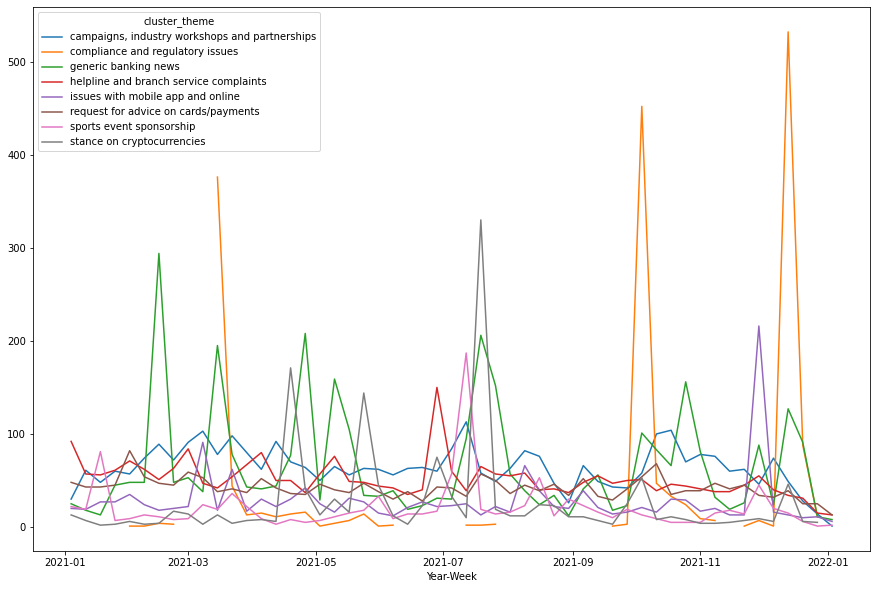

In [6]:
# plot the topic mentions over time
agg_df = master_df.groupby(['Year-Week', 'cluster_theme'])['count'].sum().reset_index()
pivot_df = agg_df.pivot(index='Year-Week', columns='cluster_theme', values='count')

pivot_df.plot(figsize=(15, 10))

The above spikes can be dug into to understand what is driving them, for example:
- the latter two spikes coincide with a regulatory investigation into anti-money laundering checks and the subsequent fines issued
- the large spike in "mobile and online complaints" in December aligns with a reported issue with the online banking app servers
- the August spike in cryptocurrency comments was the result of a bank initiative to counter scams by capping transfer to crypto exchanges

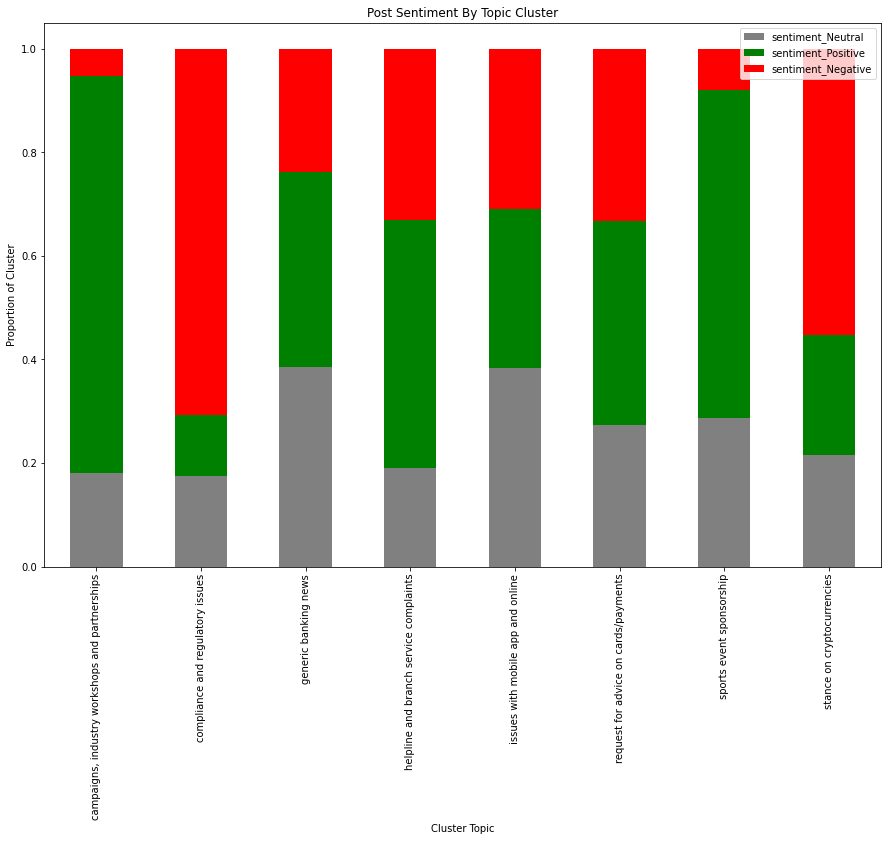

In [7]:
# plot sentiment by cluster
agg_df = master_df.groupby(['cluster_theme'])[['count', 'sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral']].sum()
agg_df[['sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral']] = agg_df[['sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral']].div(agg_df['count'], axis=0)

# plot the stacked bar chart to show frequency of posts by sentiment
agg_df[['sentiment_Neutral', 'sentiment_Positive', 'sentiment_Negative']].plot.bar(
    stacked=True, color = ['grey', 'green', 'red'], width=0.5, figsize=(15,10))

plt.xticks(rotation = 90)
plt.title('Post Sentiment By Topic Cluster')
plt.ylabel('Proportion of Cluster')
plt.xlabel('Cluster Topic')

plt.show()

Rather unsurprisingly the posts relating to "campaigns, industry workshops and partnerships", and posts related to "event sponsorship" are overwhelmingly positive. This in part could be don the the fact these are published from original/own-brand pages as opposed to organic consumer conversations.

Meanwhile "compliance and regulatory" comments, are negative - reflecting the serious nature of topic being mentioned. When it comes to the likes of "issues with app and online banking", investigation of these posts would suggest that people often just posts to alter the bank of the issue, using neutral language, hence the large portion of neutral sentiment found. 

Interestingly the negative sentiment associated with the "Stance on cryptocurrencies" cluster would indicate that consumers reacted badly to the news of restrictions on their ability to transfer to exchanges, and would be something for the PR team to investigate to understand if the messaging of the announcement could have been improved

In [24]:
# analyse engagement by cluster
master_df[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']] = master_df[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']].astype(int)
master_df['engagement_score'] = master_df[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']].sum(axis=1)

In [28]:
# compute the average engagment by cluster
agg_df = master_df.groupby('cluster_theme')[['count', 'engagement_score']].sum()
agg_df['average_engagement'] = round(agg_df['engagement_score']/agg_df['count'],1)

agg_df[['count', 'average_engagement']].sort_values('average_engagement', ascending=False)

,count,average_engagement
cluster_theme,,
sports event sponsorship,1095,27.8
compliance and regulatory issues,1754,11.6
generic banking news,3488,7.5
stance on cryptocurrencies,1375,7.4
"campaigns, industry workshops and partnerships",3386,7.1
request for advice on cards/payments,2220,3.5
issues with mobile app and online,1487,2.0
helpline and branch service complaints,2747,1.4


<AxesSubplot:xlabel='Year-Week'>

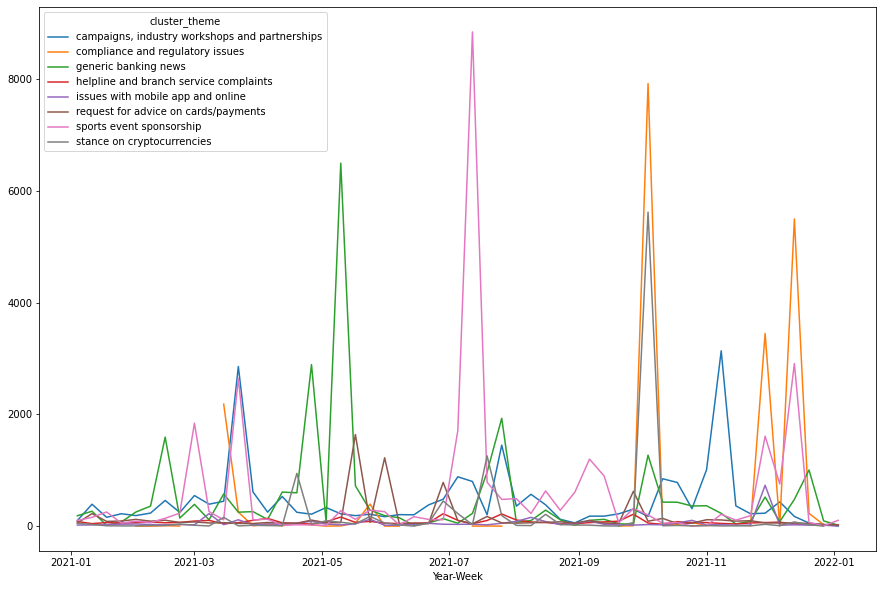

In [29]:
agg_df = master_df.groupby(['Year-Week', 'cluster_theme'])['engagement_score'].sum().reset_index()
pivot_df = agg_df.pivot(index='Year-Week', columns='cluster_theme', values='engagement_score')

pivot_df.plot(figsize=(15, 10))

And there you have it, perhaps as expected, the posts issued around sports event sponsorship (albeit, most likely issued by own-brand account - although worth proving with follow-up) drives the highest average engagement per post. This indicates that as a marketing mechanism, to get your brand exposed in a positive manner, this approach reaps multiplier effects (with users organically liking or sharing content)

### Supervised Modelling

The final stage of this project is to prepare training data from a number of our interesting well formed clusters, and train a supervised model for classifying. 

##### Disclaimer:
It is worth noting, that the volumes of tweets we have for training a classifier are relatively small - e.g. just a couple thousand examples of each. For building supervised models, it is not recommended to use such small datasets of training data for each class, as the performance of a model is almost always related to the volume of training data - with more training data tending to lead to improved results.

However, for providing a worked example of how we can train a classifier for future categorisation of tweets, we will progress with some of the clusters we have - although we should not expect our model to perform to an extremely high standard (but let's give it a go nonetheless)!

##### Motivation:
So why exactly would we want to train a supervised model, if we can already perform analysis on our clustered data? Well the answer is simple, the clustering approach is not repeatable, and will not enable us to consistently analyse new data as it comes in.

Imagine we pull another 3 months of new data (something we will train below). In this case, if we were to rerun our clustering algorithm we would get different cluster forming and would need to repeat the manual investigation of each to determine what they are discussing - this is because of the approach taken by the KMeans algorithm, which looks to split the whole dataset, therefore as we add new data, we get new clusters.

Therefore, to ensure we build a capability that is consistent in how it classifies tweets, and can be rerun/repeated at speed and scale, we want to build a supervised model.

##### Options:
The choice of embedding and classification model is in our case going to be heavily influenced by the volume of training data that we have. Based on previous experience, simpler models tend to perform better when the volume of training dta available is limited.

For this reason we will use a logistic regression model as our classifier.

The next point to get to terms with is the type of classification we are interested in. Generally speaking there are two types of classification problems: Multi-Class and Multi-Label.

- Multi-Class: Every data point (tweet) can be assigned to just a single label (topic). In each case the classifier returns the probabilities associated with each class (with sum of probabilities equalling 1), while the label with the highest probability is assigned to the data point (tweet)

- Multi-Label: Every data point can have a number of labels (or no label at all). It is effectively like training an independent model for each class and then returning a probability for each class individually, and labelling the data point against each class if the probability is above a given threshold.


Given that some of our data points will not be assigned to a class (i.e. generic tweet that is not related to the topics identified in the neater clusters) we will opt for the multi-lablel approach. This is because it mainly addresses the issue that a tweet can be assigned no label at all. If we were not to use this approach, we would need to create an NA class into which we would bucket a range of random tweets, but the risk here is that we hav such a broard range of tweets (or indeed overfit if we need to make the NA training set large to account for the proportion of tweets assigned to it), that we incorrectly label our tweets to it

In [ ]:
tweets_df = 